In [549]:
import os
import sqlite3
import scipy.stats as stats
import pandas as pd
import numpy as np
from zipfile import ZipFile
from matplotlib import pyplot as plt

In [550]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
ZIPPED_DATA_DIR = os.path.join(BASE_DIR, "zippedData")

In [551]:
dfs = {}

sql_db_file = "im.db"
movie_info_q = """
        SELECT * FROM principals
        JOIN movie_ratings USING(movie_id)
        JOIN movie_akas USING(movie_id)
        ;"""
movie_people_q = """
        SELECT *
        FROM principals
        JOIN persons USING(person_id)
        ;"""

with ZipFile(os.path.join(ZIPPED_DATA_DIR, f"{sql_db_file}.zip"), 'r') as zip:
    zip.extract(sql_db_file)

    conn = sqlite3.connect(sql_db_file)
    
    dfs["movie_info_df"] = pd.read_sql(movie_info_q, conn)
    dfs["movie_people_df"] = pd.read_sql(movie_people_q, conn)

    os.remove(sql_db_file)


for file_name in os.listdir(ZIPPED_DATA_DIR):
    if not file_name in [sql_db_file + ".zip", ".DS_Store"]:
        sep = "\t" if "tsv" in file_name else ","
        try:
            dfs[file_name.split(".")[-3]] = pd.read_csv(os.path.join(ZIPPED_DATA_DIR, file_name), sep=sep, encoding="unicode_escape")
        except Exception as e:
            print(e, file_name)

In [552]:
for df in dfs:
    print(df)
    print(dfs.get(df).columns)
    print("\n")

movie_info_df
Index(['movie_id', 'ordering', 'person_id', 'category', 'job', 'characters',
       'averagerating', 'numvotes', 'ordering', 'title', 'region', 'language',
       'types', 'attributes', 'is_original_title'],
      dtype='object')


movie_people_df
Index(['movie_id', 'ordering', 'person_id', 'category', 'job', 'characters',
       'primary_name', 'birth_year', 'death_year', 'primary_profession'],
      dtype='object')


movies
Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')


reviews
Index(['id', 'review', 'rating', 'fresh', 'critic', 'top_critic', 'publisher',
       'date'],
      dtype='object')


movie_info
Index(['id', 'synopsis', 'rating', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio'],
      dtype='object')


movie_budgets
Index(['id', 'release_date', 'movie', 'produ

In [553]:
budget_df = dfs.get("movie_budgets").replace('[\$,]', '', regex=True).apply(pd.to_numeric, errors="ignore")
budget_df = budget_df[budget_df["production_budget"] > 5000000].replace(0, np.nan).dropna()
budget_df["domestic_ROI"] = (budget_df["domestic_gross"] - budget_df["production_budget"]) / budget_df["production_budget"]
budget_df["worldwide_ROI"] = (budget_df["worldwide_gross"] - budget_df["production_budget"]) / budget_df["production_budget"]

dfs["movie_budgets"] = budget_df

In [554]:

money_and_info_df = dfs.get("movie_budgets").join(dfs.get("movie_info"), on="id", how="inner", lsuffix="_budget")
money_and_info_df.sort_values("worldwide_ROI", ascending=False, inplace=True)
money_and_info_df[["theater_date", "dvd_date"]] = money_and_info_df[["theater_date", "dvd_date"]].apply(pd.to_datetime, errors="ignore", infer_datetime_format=True)
money_and_info_df.head()
# money_and_info_df["WW_ROI_Cat"] = pd.cut(money_and_info_df.worldwide_ROI, bins=5, labels=False)
# plt.hist(money_and_info_df.WW_ROI_Cat)

# REMOVE OUTLIERS ———————————————————————————
ww_ROI = money_and_info_df["worldwide_ROI"]
Q1 = money_and_info_df["worldwide_ROI"].quantile(0.25)
Q3 = money_and_info_df["worldwide_ROI"].quantile(0.75)
IQR = Q3 - Q1

best_df = money_and_info_df[money_and_info_df.worldwide_ROI > Q3 + 1.5 * IQR]
money_and_info_df = money_and_info_df[money_and_info_df["worldwide_ROI"] < Q3 + 1.5 * IQR][money_and_info_df["worldwide_ROI"] > Q1 - 1.5 * IQR]

/var/folders/cp/k4r1_sbx687dqn2rzgz3t7n40000gn/T/ipykernel_7854/2883756889.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  money_and_info_df = money_and_info_df[money_and_info_df["worldwide_ROI"] < Q3 + 1.5 * IQR][money_and_info_df["worldwide_ROI"] > Q1 - 1.5 * IQR]


In [555]:
best_writers = money_and_info_df[["writer", "worldwide_ROI"]][money_and_info_df["writer"].str.contains("\|")==False].groupby("writer").median().sort_values("worldwide_ROI", ascending=False)

best_directors = money_and_info_df[["director", "worldwide_ROI"]].groupby("director").median().sort_values("worldwide_ROI", ascending=False)

print(best_writers[:5], "\n",  best_directors[:5])

                 worldwide_ROI
writer                        
Wendell Mayes         1.529053
Jan Sardi             1.497769
Lawrence Kasdan       1.495098
Ken Englund           1.454209
Eric Bogosian         1.421871 
                    worldwide_ROI
director                        
Otto Preminger          1.529053
Bruce Beresford         1.497769
Steven Spielberg        1.495098
Herbert Wilcox          1.454209
Richard Linklater       1.421871


SpearmanrResult(correlation=0.8409983414646023, pvalue=0.0)
SpearmanrResult(correlation=0.1765349117966718, pvalue=7.87316434617963e-28)


Text(0, 0.5, 'Worldwide ROI')

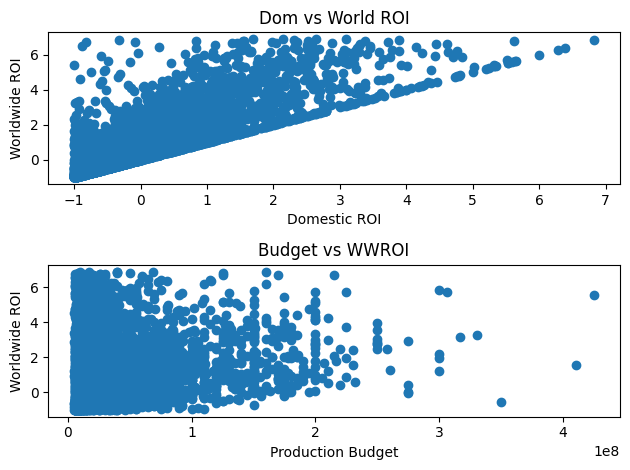

In [568]:
fig, (ax1, ax2) = plt.subplots(2, tight_layout=True)

print(stats.spearmanr(money_and_info_df.domestic_ROI, money_and_info_df.worldwide_ROI))
ax1.scatter(money_and_info_df.domestic_ROI, money_and_info_df.worldwide_ROI)
ax1.set_title("Dom vs World ROI")
ax1.set_xlabel("Domestic ROI")
ax1.set_ylabel("Worldwide ROI")

print(stats.spearmanr(money_and_info_df.production_budget, money_and_info_df.worldwide_ROI))
ax2.scatter(money_and_info_df.production_budget, money_and_info_df.worldwide_ROI)
ax2.set_title("Budget vs WWROI")
ax2.set_xlabel("Production Budget")
ax2.set_ylabel("Worldwide ROI")

SpearmanrResult(correlation=0.01743417838510342, pvalue=0.3699240815132149)

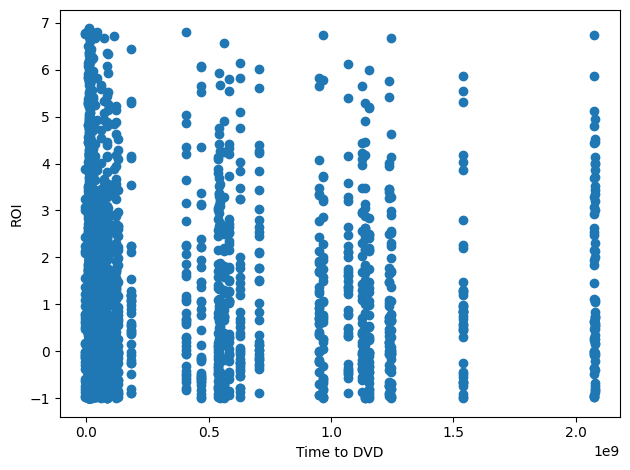

In [567]:
from datetime import timedelta

date_ROI = money_and_info_df[["worldwide_ROI", "theater_date", "dvd_date"]]
date_ROI = date_ROI.dropna()
date_ROI["time_to_dvd"] = (date_ROI.dvd_date - date_ROI.theater_date).apply(timedelta.total_seconds)

fig, ax = plt.subplots(tight_layout=True)
ax.scatter(date_ROI.time_to_dvd, date_ROI.worldwide_ROI)
ax.set_xlabel("Time to DVD")
ax.set_ylabel("ROI")
stats.spearmanr(date_ROI.time_to_dvd, date_ROI.worldwide_ROI)

In [558]:
def get_genre_df(from_df) -> pd.DataFrame:
    _genres_df = pd.DataFrame()

    for idx, row in from_df[["genre", "worldwide_ROI"]].dropna().iterrows():
        if "|" in row.genre:
            genres = row.genre.split("|")
        else:
            genres = [row.genre]

        for genre in genres:
            new_row = row
            new_row.genre = genre
            new_row = pd.DataFrame(new_row).transpose()
            
            _genres_df = pd.concat([_genres_df, new_row])
    
    return _genres_df

genres_df = get_genre_df(money_and_info_df)
best_genres_df = get_genre_df(best_df)

In [559]:
print("ALL\n", genres_df.groupby("genre").median().sort_values("worldwide_ROI", ascending=False)[:5])

print("\nHIGHEST PERFMORING\n", best_genres_df.groupby("genre").median().sort_values("worldwide_ROI", ascending=False)[:5])

ALL
                              worldwide_ROI
genre                                     
Animation                         1.433886
Sports and Fitness                1.324828
Musical and Performing Arts       1.009514
Western                           0.953031
Television                        0.910158

HIGHEST PERFMORING
                     worldwide_ROI
genre                            
Sports and Fitness      16.114729
Animation               15.272461
Special Interest        12.786336
Kids and Family         11.229174
Classics                10.785354


In [560]:
actors_df = dfs.get("movie_people_df")
actors_df = actors_df[actors_df["primary_profession"] == "actor"][["movie_id", "primary_name"]].dropna().drop_duplicates()

movies_df = dfs.get("movie_info_df")
movies_df = movies_df[movies_df["attributes"].apply(lambda x: not isinstance(x, str))][movies_df.is_original_title == 1][["movie_id", "title"]].dropna().drop_duplicates()

actor_movies_df = actors_df.merge(movies_df, on="movie_id", how="inner").rename(columns={"primary_name" :"actor"})

/var/folders/cp/k4r1_sbx687dqn2rzgz3t7n40000gn/T/ipykernel_7854/3236445062.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_df = movies_df[movies_df["attributes"].apply(lambda x: not isinstance(x, str))][movies_df.is_original_title == 1][["movie_id", "title"]].dropna().drop_duplicates()


In [561]:
# The IMDB data is terrible and no conclusions should be drawn using it.
actors_df[actors_df.primary_name.isin(["Christian Bale", "Tom Hanks", "Tom Cruise", "Morgan Freeman", "Ryan Gosling", "Dwayne Johnson", "Scarlett Johansson"])] # garbage  

,movie_id,primary_name


In [562]:
actor_value_df = actor_movies_df.merge(money_and_info_df[["movie", "worldwide_ROI"]].rename(columns={"movie" :"title"}), on="title", how="inner")[["actor", "worldwide_ROI"]]
actor_value_df.groupby("actor").median().sort_values("worldwide_ROI", ascending=False)

,worldwide_ROI
actor,
Costas Mandylor,6.866781
Rafe Spall,6.681016
Ty Simpkins,6.669092
Corey Hawkins,6.220821
Phi Vu,6.131055
...,...
Sergio Peris-Mencheta,-0.994154
Nao Ohmori,-0.995463
Trieu Tran,-0.997398


In [579]:
rating_roi_df = money_and_info_df[["rating", "worldwide_ROI"]]

print(rating_roi_df.groupby("rating").median().sort_values("worldwide_ROI", ascending=False),"\n\n", rating_roi_df.rating.value_counts())

        worldwide_ROI
rating               
NR           0.811367
PG           0.796266
R            0.783617
G            0.765591
PG-13        0.692662 

 R        1664
NR        984
PG        526
PG-13     416
G         149
Name: rating, dtype: int64


In [582]:
money_and_info_df[["production_budget", "worldwide_ROI"]]

,production_budget,worldwide_ROI
749,69000000,6.876298
134,160000000,6.869998
1378,40000000,6.867743
2878,17000000,6.866781
3552,10000000,6.861077
...,...,...
2480,21000000,-0.999172
1242,46500000,-0.999521
2152,26000000,-0.999808
3818,9000000,-0.999862


In [586]:
def normalize(value, min, max):
    return (value - min) / (max - min)

x = range(-100, 110, 10)
print(list(x))
# 

y = [num / max(x) for num in x]
print(y)

[-100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
